# Analyse des avions entre eux  
Projet de statistiques descriptives MACS3, dans le cadre du cours de Jérôme Lacaille.

_Version 1.0 [03/12/2023] HUSSON Félix_

Après avoir analysé un unique vols, puis les vols entre eux maintenant on essayeras de déterminer des caractérisiques de l'avion

In [1]:
%reload_ext autoreload
%autoreload 2

# module
import sys
sys.path.append("../")
from src import * 

# chemin vers la donnee 
data_dir = 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive/'
filelist = glob.glob(data_dir + '*.h5')
filelist

['C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01_dask.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02_dask.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03_dask.h5']

In [2]:
#on cree notre dataframe avec DASK
ddf1 = lire_hdf_dask(filelist[0], repertoire= data_dir)
#on récupère une liste de booleen où chaque composante fait reférance à une partition 
I = ddf1.map_partitions(lambda df: eliminate_records(df)).compute()
#on sélectione dans un nouveau dataframe les partitions qui ne sont pas anormales 
DDF1=ddf1.partitions[I==False]
# on normalise toute les données excepté les variables booleen 
ddf_norm1 = DDF1.map_partitions(lambda df : normalize(df))

ddf2 = lire_hdf_dask(filelist[2], repertoire= data_dir)
I = ddf2.map_partitions(lambda df: eliminate_records(df)).compute()
DDF2=ddf2.partitions[I==False]
ddf_norm2 = DDF2.map_partitions(lambda df : normalize(df))

ddf3 = lire_hdf_dask(filelist[3], repertoire= data_dir)
I = ddf3.map_partitions(lambda df: eliminate_records(df)).compute()
DDF3=ddf3.partitions[I==False]
ddf_norm3 = DDF3.map_partitions(lambda df : normalize(df))

In [3]:
def deriv_glissante(df):
    
    #on cree une fonction qui prend un data frame qui l'augment de la valeur dy et qui renvoit  un nouveau dataframe contenant que le monté 
    #ATTENTION LA FONCTION PRENDS EN ENTREE DES DONNEES NORMALISEE
    
    dy=np.zeros(len(df))
    
    #on fait une moyenne glissante pour éviter d'être sensible aux bruit. En effet pour le cacul de dérivée le bruit 
    #fausse trés rapidement les données
    y = df['ALT'].rolling(window = 20).mean()
    I = range(y.index[0], y.index[-1],20)
    #calcul de la derivée
    dy[0:len(I)-1] = y[I[1:]].values- y[I[:-1]].values
    #creation d'une nouvelle colonne dans le dataframe vitesse de mont en ft/s
    df['dy']=dy
    #on selectionne le dataframe où les dérivées sont plus grande que 0.01 (la montée)
    df_monte=df[df['dy']>0.01]
    I4=np.zeros(len(df_monte))
    #on verifie qu' avec un shift des données on retombe bien sur les mêmes indices cela permet d'éviter 
    # de prendre en compte des valeurs qui ne serait pas dans la phase de la montée 
    #Attention cette façon de faire est lié aux cas d'un vol d'avion (l'hypothèse admise est que l'avion ne monte qu'une fois)
    #Et s'il existe plus de 6 données anormale consécutives alors elles seront prise en compte 
    
    I4[5:]=df_monte.index[5:]==(df_monte.index+5)[:-5]
    I4[:5]=1
    df_monte2=df_monte[I4==1]

    #je rajoute une nouvelle fois la dérivé cette fois non moyennée pour garder la correspondance entre les variable i.e a un instant t la derivé et les autres mesures sont aussi prise à l'instant t
    vy= np.empty(len(df))
    y2 = df['ALT'].values
    vy[:-1] = y2[1:]-y2[:-1]
    vy[-1]=0
    df['vy']=vy
    
    


    return df_monte2

In [9]:
COR_EGT_vy=[]
I=[]
for i in range (0,990):
    I.append(i)
    df13=ddf_norm1.partitions[i].compute()
    df_monte3=deriv_glissante(df13)
    I_monte3=df_monte3.index*20
    #creation dataframe montée
    df_CORR=df13.iloc[I_monte3]
    #calcul des corélation
    CORR=df_CORR.corr()
    COR_EGT_vy.append(CORR['vy']['EGT_2'])

Médiane du coefficient de corrélation de la vitesse et de l'EGT :
0.5412321817624457


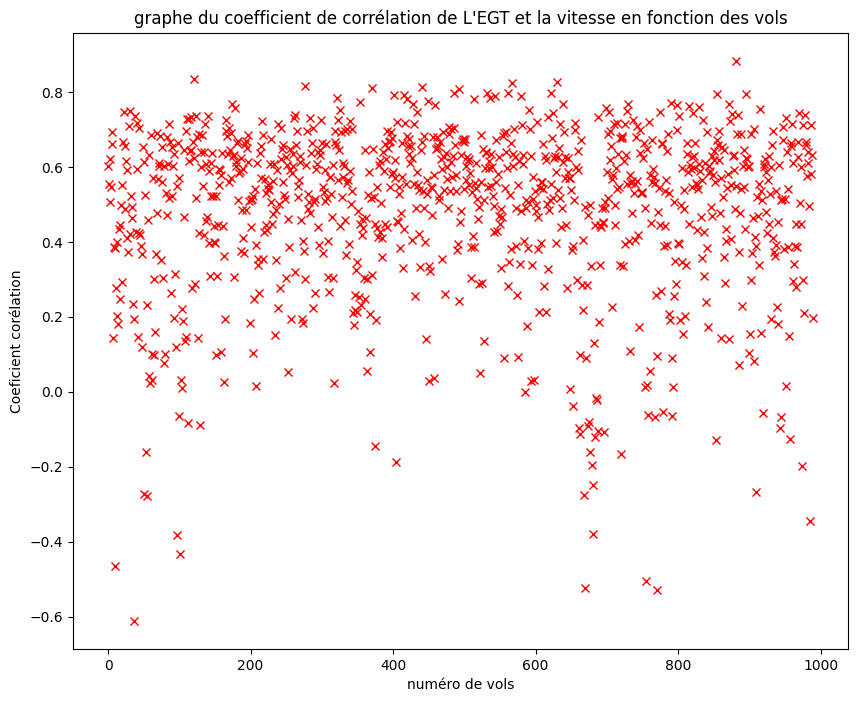

In [10]:
print("Médiane du coefficient de corrélation de la vitesse et de l'EGT :")
print(np.median(COR_EGT_vy))


plt.figure(figsize=(10,8))
plt.plot(I,COR_EGT_vy,'rx')

plt.xlabel('numéro de vols')
plt.ylabel('Coeficient corélation')
plt.title("graphe du coefficient de corrélation de L'EGT et la vitesse en fonction des vols");

In [19]:
COR_EGT_vy2=[]

I=[]
for i in range (0,990,5):
    I.append(i)
    df13=ddf_norm2.partitions[i].compute()
    df_monte3=deriv_glissante(df13)
    I_monte3=df_monte3.index*20
    df_CORR=df13.iloc[I_monte3]
    CORR=df_CORR.corr()
    if np.isnan(CORR['vy']['EGT_2'])==True:
        CORR['vy']['EGT_2']=0
        
    COR_EGT_vy2.append(CORR['vy']['EGT_2'])
 
    

Médiane du coefficient de corrélation de la vitesse et de l'EGT :
0.5214999224274457


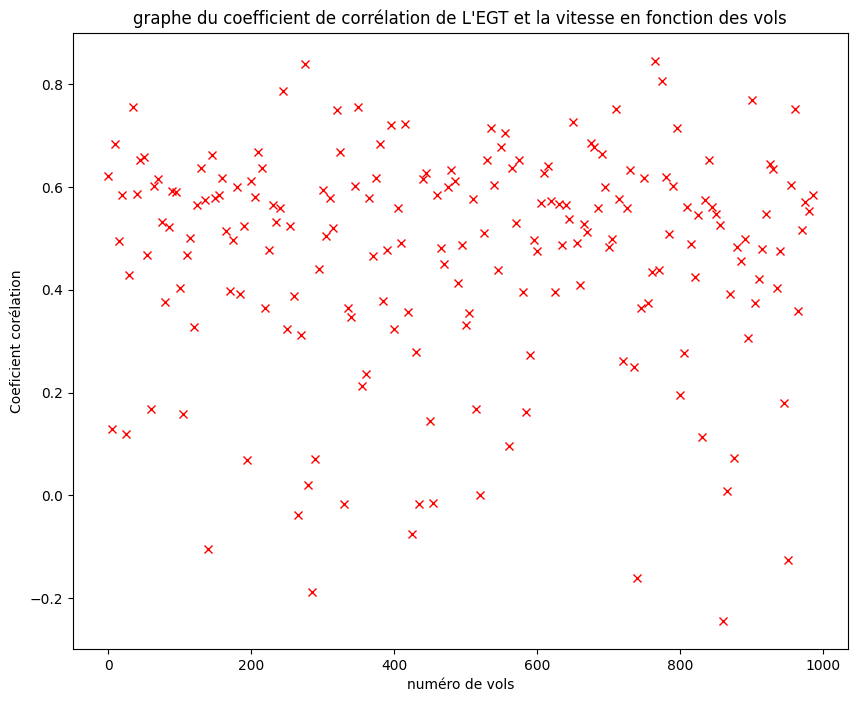

In [20]:
print("Médiane du coefficient de corrélation de la vitesse et de l'EGT :")
print(np.median(COR_EGT_vy2))


plt.figure(figsize=(10,8))
plt.plot(I,COR_EGT_vy2,'rx')

plt.xlabel('numéro de vols')
plt.ylabel('Coeficient corélation')
plt.title("graphe du coefficient de corrélation de L'EGT et la vitesse en fonction des vols");

In [21]:
COR_EGT_vy3=[]

I=[]
for i in range (0,990,5):
    I.append(i)
    df14=ddf_norm3.partitions[i].compute()
    df_monte4=deriv_glissante(df14)
    I_monte4=df_monte4.index*20
    df_CORR=df14.iloc[I_monte4]
    CORR=df_CORR.corr()
    if np.isnan(CORR['vy']['EGT_2'])==True:
        CORR['vy']['EGT_2']=0
        
    COR_EGT_vy3.append(CORR['vy']['EGT_2'])
 

Médiane du coefficient de corrélation de la vitesse et de l'EGT :
0.5214999224274457


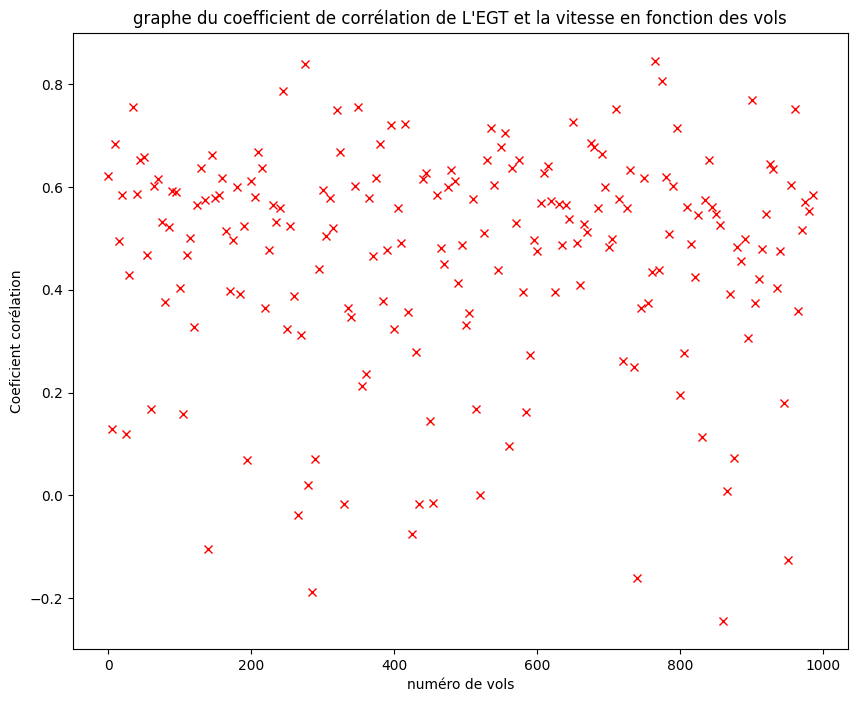

In [22]:
print("Médiane du coefficient de corrélation de la vitesse et de l'EGT :")
print(np.median(COR_EGT_vy3))


plt.figure(figsize=(10,8))
plt.plot(I,COR_EGT_vy3,'rx')

plt.xlabel('numéro de vols')
plt.ylabel('Coeficient corélation')
plt.title("graphe du coefficient de corrélation de L'EGT et la vitesse en fonction des vols");

On retrouve bien des valeurs similaires au premier avion, une mediane proche de 0.5 pour les 3 avions